In [37]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran
import matplotlib.pyplot as plt
from fuzzywuzzy import process

# Load crop production data
crop_df = pd.read_csv('Crop_Production_data.csv')

# ['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area', 'Production']

# Basic checks
print(f"Time range: {crop_df.Crop_Year.min()} - {crop_df.Crop_Year.max()}")
print(f"Districts: {crop_df.District_Name.nunique()}")
print(f"Missing values: \n {crop_df.isnull().sum()}")

Time range: 1997 - 2015
Districts: 644
Missing values: 
 State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Production       3730
dtype: int64


In [41]:
# Load India districts shapefile (district boundries files)
gdf = gpd.read_file("IND_adm\IND_adm2.shp")

# Clean names in both datasets
def clean_names(df, col):
    return df[col].str.strip().str.title()



# Modify the name of the districts from csv which aren't matching with shp file :
crop_df['State_Name'] = crop_df['State_Name'].replace('Uttarakhand','Uttaranchal')
crop_df['State_Name'] = crop_df['State_Name'].replace('Odisha','Orissa')
crop_df['District_Name'] = crop_df['District_Name'].replace('Y.S.R.','Cuddapah')
crop_df['District_Name'] = crop_df['District_Name'].replace('Purba Medinipur','East Midnapore')
crop_df['District_Name'] = crop_df['District_Name'].replace('Pashchim Medinipur','West Midnapore')
crop_df["District_Name"] = crop_df["District_Name"].replace('Bangalore', 'Bangalore URBAN')

# Clean the naming :
crop_df['State_Name'] = clean_names(crop_df, 'State_Name')
crop_df['District_Name'] = clean_names(crop_df, 'District_Name')
gdf['STATE'] = clean_names(gdf, 'NAME_1')        
gdf['District'] = clean_names(gdf, 'NAME_2')  

#gdf.head()

# Statistical overview of the data
crop_df.describe(include='all')

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
count,246091,246091,246091.000000,246091,246091,2.460910e+05,2.423610e+05
unique,33,630,NaN,8,126,NaN,NaN
top,Uttar Pradesh,Bangalore Rural,NaN,Kharif,Rice,NaN,NaN
freq,33306,1466,NaN,93584,15104,NaN,NaN
mean,NaN,NaN,2005.643018,NaN,NaN,1.200282e+04,5.825034e+05
std,NaN,NaN,4.952164,NaN,NaN,5.052340e+04,1.706581e+07
min,NaN,NaN,1997.000000,NaN,NaN,4.000000e-02,0.000000e+00
25%,NaN,NaN,2002.000000,NaN,NaN,8.000000e+01,8.800000e+01
50%,NaN,NaN,2006.000000,NaN,NaN,5.820000e+02,7.290000e+02
75%,NaN,NaN,2010.000000,NaN,NaN,4.392000e+03,7.023000e+03


In [42]:
## District Name macthing with shp file and corrections:

# Ref: i) https://www.datacamp.com/tutorial/fuzzy-string-python
#      ii) https://pathindependence.wordpress.com/2015/10/31/tutorial-fuzzywuzzy-string-matching-in-python-improving-merge-accuracy-across-data-products-and-naming-conventions/

## Identify Mismatches in Shap file Naming:
# Get unique state-district pairs from both datasets
df_districts = crop_df.groupby(['State_Name', 'District_Name']).size().reset_index()
shp_districts = gdf.groupby(['STATE', 'District']).size().reset_index()

# Find mismatches
mismatches = []
for idx, row in df_districts.iterrows():
    state = row['State_Name']
    district = row['District_Name']
    
    # Get matching districts from shapefile for this state
    shp_districts_for_state = shp_districts[shp_districts['STATE'] == state]['District'].tolist()
    
    if district not in shp_districts_for_state:
        mismatches.append({
            'State': state,
            'CSV_District': district,
            'Shapefile_Districts': shp_districts_for_state
        })

## Fuzzy Match Correction Suggestions ::

# Generate correction map
correction_map = {}
print("Suggested Corrections:")
for mismatch in mismatches:
    state = mismatch['State']
    csv_district = mismatch['CSV_District']
    candidates = mismatch['Shapefile_Districts']
    
    if candidates:
        match, score = process.extractOne(csv_district, candidates)
        if score > 70:  # 85 was giving much more mismatch
            # Add to correction map
            if state not in correction_map:
                correction_map[state] = {}
            correction_map[state][csv_district] = match
            
            # Print Correction :
            #print(f"{state}:")
            #print(f"  '{csv_district}' → '{match}' (confidence: {score}%)")

# Print the generated correction map
#print("\n Auto  Correction Map:")
#print(correction_map)        

# Update the dataframe with corrections
crop_df['District_Name'] = crop_df.apply(
    lambda x: correction_map.get(x['State_Name'], {}).get(x['District_Name'], x['District_Name']), 
    axis=1
)


Suggested Corrections:


<Figure size 1000x800 with 0 Axes>

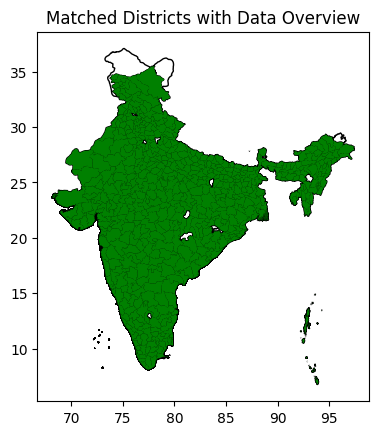

In [43]:
## Group District with state and distinct count to confirm mapping on shp file:

# Group districts with respective state to count the unique data point avialable:
district_counts = crop_df.groupby(['State_Name','District_Name'])['District_Name'].value_counts().reset_index()
district_counts.columns = ['State_Name','District_Name','Count']

# SHAP file data naming change to all captial letter
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper()  # State column in shapefile

# CSV file data naming change to all captial letter
district_counts['State_Name'] = district_counts['State_Name'].str.upper()
district_counts['District_Name'] = district_counts['District_Name'].str.strip().str.upper()

# merge data {csv and shap}:
merged_data = pd.merge(gdf,district_counts,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)


# Copy District with no data
unmerge_struct = merged_data[merged_data['Count'].isna()]


# Drop the districts with no count/data available:
merged_data.dropna(subset=['Count'], inplace=True)

ax = plt.figure(figsize=(10, 8))

base = gdf.plot(color='white', edgecolor='black')
merged_data.plot(ax=base, color='green', markersize=0.1)

# Overlay state boundaries
#states_gdf.boundary.plot(ax=base, color='black', linewidth=1.2)

plt.title('Matched Districts with Data Overview')
plt.show()


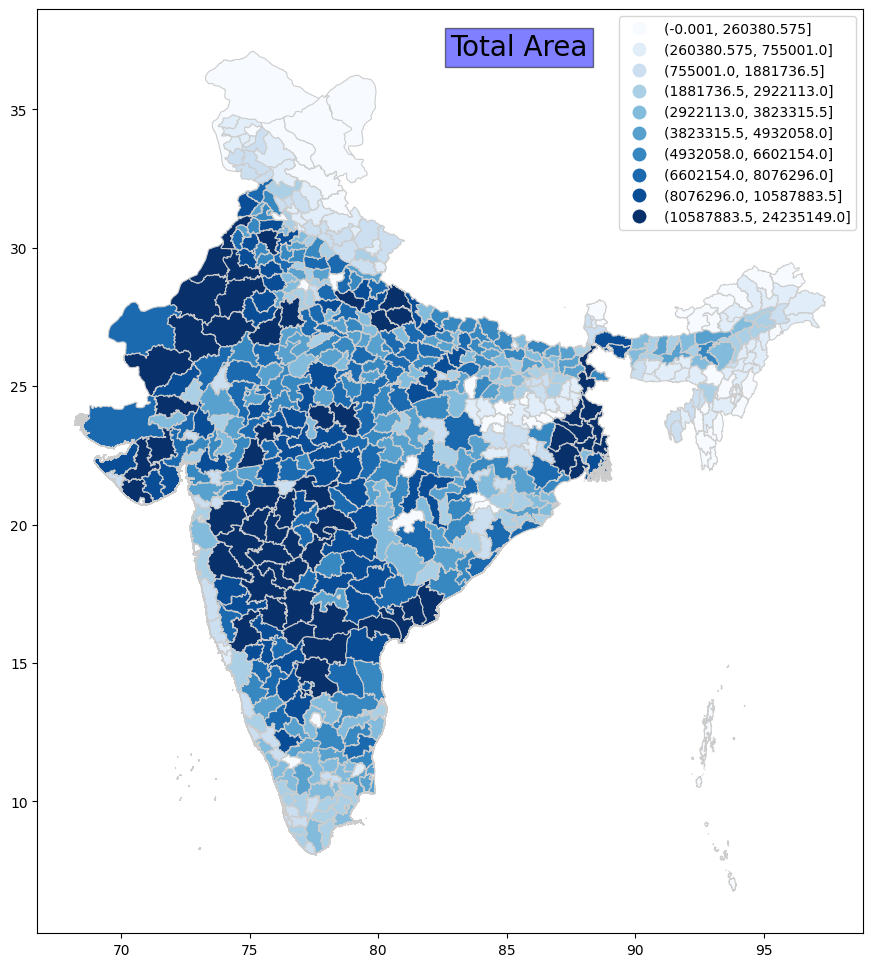

In [44]:
# Creating charts for Total Area
plt.figure(figsize=(12,12))
    
plt_data = crop_df.groupby(['State_Name','District_Name'])['Area'].sum().reset_index()
plt_data.columns = ['State_Name','District_Name','Area']

# SHAP file data naming change to all captial letter
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper()  # State column in shapefile

# CSV file data naming change to all captial letter
plt_data['State_Name'] = plt_data['State_Name'].str.upper()
plt_data['District_Name'] = plt_data['District_Name'].str.strip().str.upper()

merged_data = pd.merge(gdf,plt_data,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)

# Copy District with no data
unmerge_struct = merged_data[merged_data['Area'].isna()]

merged_data.Area = merged_data.Area.fillna(0)
merged_data.Area = pd.qcut(merged_data.Area,q=10,duplicates='drop')

ax = merged_data.plot(column='Area',cmap='Blues', linewidth=0.8, ax=plt.gca(), edgecolor='0.8', legend=True)
plt.text(0.5,0.95,'Total Area',transform=ax.transAxes, bbox=dict(facecolor='blue',alpha=0.5),fontsize=20)

plt.show()